#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/project/'

### **(2) 라이브러리 설치 및 불러오기**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional, Input
from keras.optimizers import Adam

from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [6]:
# 3번 데이터셋 불러오기
data_03 = joblib.load(path + 'data03.pkl')
data_03

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,H_D,H_D_1,H_D_2,WeekDay,Month,Category_Qty,City_CustCount,target
0,2014-01-02,4422,9853.0,7109.454545,8807.200000,No,No,No,Thursday,1,10142.0,45969,15153.0
1,2014-01-03,4167,8647.0,7109.454545,8807.200000,No,No,No,Friday,1,8980.0,42386,15606.0
2,2014-01-04,5341,15153.0,13476.000000,8807.200000,No,No,No,Saturday,1,15684.0,52293,7900.0
3,2014-01-05,5123,15606.0,13476.000000,8807.200000,No,No,No,Sunday,1,15606.0,49199,7188.0
4,2014-01-06,3917,7900.0,7109.454545,8807.200000,No,No,No,Monday,1,8083.0,39105,8800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,2017-02-22,3834,7856.0,8994.050000,10487.607143,No,No,No,Wednesday,2,8118.0,38673,10208.0
1140,2017-02-23,3955,8018.0,8994.050000,10487.607143,No,No,No,Thursday,2,8316.0,39881,12361.0
1141,2017-02-24,4549,10208.0,8994.050000,10487.607143,No,No,No,Friday,2,10689.0,43170,10108.0
1142,2017-02-25,4619,12361.0,14221.500000,10487.607143,No,No,No,Saturday,2,13073.0,46801,10006.0


In [7]:
df_42 = joblib.load(path + 'data42.pkl')
df_42

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,H_D,H_D_1,H_D_2,WeekDay,Month,Category_Qty,City_CustCount,target
0,2014-01-02,4422,76.0,70.681818,73.333333,No,No,No,Thursday,1,1962.622000,45969,78.0
1,2014-01-03,4167,74.0,70.681818,73.333333,No,No,No,Friday,1,2144.997000,42386,88.0
2,2014-01-04,5341,78.0,80.625000,73.333333,No,No,No,Saturday,1,2773.830000,52293,65.0
3,2014-01-05,5123,88.0,80.625000,73.333333,No,No,No,Sunday,1,2542.787000,49199,78.0
4,2014-01-06,3917,65.0,70.681818,73.333333,No,No,No,Monday,1,1284.361970,39105,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,2017-02-22,3834,72.0,87.800000,93.035714,No,No,No,Wednesday,2,1372.673000,38673,91.0
1140,2017-02-23,3955,98.0,87.800000,93.035714,No,No,No,Thursday,2,1399.130996,39881,105.0
1141,2017-02-24,4549,91.0,87.800000,93.035714,No,No,No,Friday,2,2426.355000,43170,108.0
1142,2017-02-25,4619,105.0,106.125000,93.035714,No,No,No,Saturday,2,2267.651000,46801,78.0


In [8]:
data_12 = joblib.load(path + 'data12.pkl')
data_12

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,H_D,H_D_1,H_D_2,WeekDay,Month,Category_Qty,City_CustCount,target
0,2014-01-02,4422,9647.0,7385.727273,8614.133333,No,No,No,Thursday,1,15195.550,45969,14188.0
1,2014-01-03,4167,8879.0,7385.727273,8614.133333,No,No,No,Friday,1,13952.689,42386,14490.0
2,2014-01-04,5341,14188.0,11992.250000,8614.133333,No,No,No,Saturday,1,22059.125,52293,7614.0
3,2014-01-05,5123,14490.0,11992.250000,8614.133333,No,No,No,Sunday,1,22443.851,49199,7124.0
4,2014-01-06,3917,7614.0,7385.727273,8614.133333,No,No,No,Monday,1,11853.281,39105,8683.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,2017-02-22,3834,8931.0,9774.000000,10993.178571,No,No,No,Wednesday,2,13281.361,38673,10630.0
1140,2017-02-23,3955,8643.0,9774.000000,10993.178571,No,No,No,Thursday,2,12888.873,39881,12978.0
1141,2017-02-24,4549,10630.0,9774.000000,10993.178571,No,No,No,Friday,2,15817.968,43170,10899.0
1142,2017-02-25,4619,12978.0,14041.125000,10993.178571,No,No,No,Saturday,2,19393.951,46801,10618.0


# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [9]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

## **(1) LSTM 모델링**

In [10]:
def preproc3d(data, timesteps, y_scale=False):
    target = 'target'
    x = data.drop(['Date', target], axis=1)
    y = data.loc[:, target]

    # 가변수화 (WeekDay, Month)
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    x['Month'] = pd.Categorical(x['Month'], categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    x = pd.get_dummies(x, columns=['WeekDay', 'Month'])

    # 'H_D', 'H_D_1', 'H_D_2' 열을 더미 변수화
    x = pd.get_dummies(x, columns=['H_D', 'H_D_1', 'H_D_2'], drop_first=True)  # drop_first=True로 'No'를 기본값으로 설정
    col_names = list(x)

    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale:
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else:
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size=120, shuffle=False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max


### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [11]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

target = 'target'

x = data_03.drop([target, 'Date'], axis =1)
y = data_03[target]

x = pd.get_dummies(x, columns=['H_D', 'H_D_1', 'H_D_2', 'WeekDay', 'Month'], drop_first=True)

x2, y2 = temporalize(x, y, 7)

x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size = 60, shuffle = False)

# 2차원으로 변환하여 스케일러 생성
scaler = MinMaxScaler().fit(flatten(x_train))

# 3차원 데이터에 스테일러 적용
x_train_s2 = scale(x_train, scaler)
x_val_s2 = scale(x_val, scaler)

scaler_y = MinMaxScaler()
y_train_s2 = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_s2 = scaler_y.transform(y_val.reshape(-1,1))

x_train_s2 = x_train_s2.astype(np.float32)
y_train_s2 = y_train_s2.astype(np.float32)
x_val_s2 = x_val_s2.astype(np.float32)
y_val_s2 = y_val_s2.astype(np.float32)

In [12]:
n_features = x_train_s2.shape[2]

clear_session()

model_LSTM_final = Sequential([LSTM(128, input_shape = (7, n_features), activation='relu'),
                              Dense(64, activation='relu'),
                              Dense(32, activation='relu'),
                              Dense(1)])

model_LSTM_final.summary()
model_LSTM_final.compile(optimizer = Adam(learning_rate = 0.001), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

hist_LSTM_final = model_LSTM_final.fit(x_train_s2, y_train_s2, epochs=50, validation_split=.2, callbacks=[early_stop]).history

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │          79,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,729 (350.50 KB)

 Trainable params: 89,729 (350.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0469 - val_loss: 0.0178
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0146 - val_loss: 0.0093
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0090 - val_loss: 0.0056
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0064 - val_loss: 0.0042
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0056 - val_loss: 0.0046
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0057 - val_loss: 0.0039
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0

* **모델링**

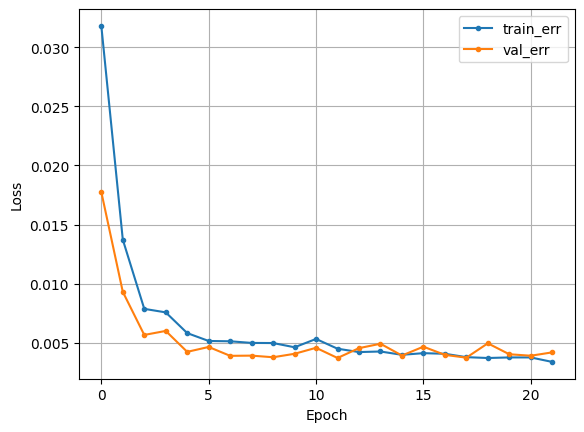

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
MAE :  1593.8403076171876
RMSE :  2024.149250332388
MAPE :  0.15033687323127642
R2_score :  0.7008879414427849


In [13]:
dl_history_plot(hist_LSTM_final)

pred = model_LSTM_final.predict(x_val_s2)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

print('MAE : ' , mean_absolute_error(y_val, pred))
print('RMSE : ', np.sqrt(mean_squared_error(y_val, pred)))
print('MAPE : ', mean_absolute_percentage_error(y_val, pred))
print('R2_score : ' , r2_score(y_val, pred))

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [13]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(data_12, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

* **모델링**

In [13]:
_, ts, nfeat = x_train.shape

clear_session()

model = Sequential([LSTM(128, input_shape = (ts, nfeat), activation='relu'),
                              #Dense(512, activation='relu'),
                              #Dense(256, activation='relu'),
                              Dense(128, activation='relu'),
                              Dense(64, activation='relu'),
                              Dropout(0.1),
                              Dense(32, activation='relu'),
                              Dropout(0.1),
                              Dense(1)])

model.summary()
model.compile(optimizer = Adam(learning_rate = 0.0001), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

hist = model.fit(x_train, y_train, epochs=150, validation_split=.2, callbacks=[early_stop]).history
dl_history_plot(hist)

In [13]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

In [13]:
rmse = mean_squared_error(y_val2, pred, squared=False)
mae = mean_absolute_error(y_val2, pred)
mape = mean_absolute_percentage_error(y_val2, pred)
r2 = r2_score(y_val2, pred)

print("┌─────────┬────────────────┐")
print(f"│ Metric  │         Value  │")
print("├─────────┼────────────────┤")
print(f"│ RMSE    │ {rmse:14.4f} │")
print("├─────────┼────────────────┤")
print(f"│ MAE     │ {mae:14.4f} │")
print("├─────────┼────────────────┤")
print(f"│ MAPE    │ {mape:14.4%} │")
print("├─────────┼────────────────┤")
print(f"│ R2      │ {r2:14.4f} │")
print("└─────────┴────────────────┘")

In [13]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [14]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(df_42, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(45.0, 196.0, (1018, 7, 28), (120, 7, 28))

* **모델링**

In [15]:
clear_session()

_, ts, nfeat = x_train.shape

# model_lstm_42 = Sequential([LSTM(4, input_shape = (ts, nfeat) ),
#                          Dense(1)])

model_lstm_42 = Sequential([
            LSTM(32, input_shape = (7, x_train.shape[2]),),
            Dense(32, activation = 'relu'),
            Dense(8, activation = 'relu'),
            Dense(1)
            ])
model_lstm_42.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32)                  │           7,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,137 (35.69 KB)

 Trainable params: 9,137 (35.69 KB)

 Non-trainable params: 0 (0.00 B)

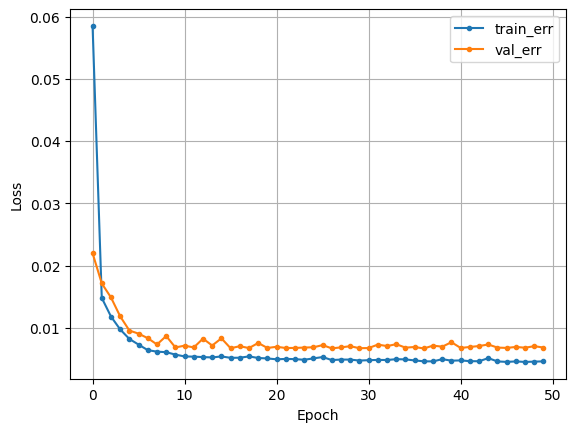

In [16]:
model_lstm_42.compile(optimizer = 'adam', loss = 'mse')
hist = model_lstm_42.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [17]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model_lstm_42.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
MAE :  11.082461961110432
MAPE :  0.1174911366551057
R2 :  0.6192498314316321


## **(2) CNN 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

* **모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data(sales_test, orders_test, oil_price_test, products, stores)
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [18]:
# !unzip /content/drive/MyDrive/project/test.zip -d /content/drive/MyDrive/project/test/

In [19]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

In [20]:
from datetime import timedelta

def make_dataset1(Product_ID):
    # 1. 기존 데이터셋 다 merge 하기
    # orders 데이터프레임
    orders_m = pd.DataFrame(orders_test)

    # sales 데이터프레임
    sales_m = pd.DataFrame(sales_test)

    # products 데이터프레임
    products_m = pd.DataFrame(products)

    # stores 데이터프레임
    stores_m = pd.DataFrame(stores)

    # 데이터프레임 병합 (Date 및 Store_ID 기준으로 orders와 sales 병합)
    merged_data = orders_m.merge(sales_m, on=['Date', 'Store_ID'])

    # products 데이터프레임과 Product_ID로 병합
    merged_data = merged_data.merge(products_m, on='Product_ID')

    # stores 데이터프레임과 Store_ID로 병합
    df = merged_data.merge(stores_m, on='Store_ID')

    # 첫 번째: 요일 추가
    df['Date'] = pd.to_datetime(df['Date']) # Date 열이 datetime 형식이 아닌 경우
    df['Weekday'] = df['Date'].dt.day_name() # 요일 추가

    # 두 번째: 평일/주말 구분 추가
    df['Day_Type'] = df['Weekday'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

    df

    # Store_ID 44, Product_ID 12 필터링
    store_id = 44
    product_ids = [Product_ID]  # 상품 번호 리스트

    df_filtered = df[(df['Store_ID'] == store_id) & (df['Product_ID'].isin(product_ids))]

    # 월별 평일 판매량 집계
    weekday_sales = df_filtered[df_filtered['Day_Type'] == 'Weekday'].groupby(df_filtered['Date'].dt.to_period('M'))['Qty'].mean().reset_index()
    weekday_sales.columns = ['Month', 'Weekday_Sales']
    weekday_sales['Month'] = weekday_sales['Month'].astype(str)  # 문자열로 변환

    # 월별 주말 판매량 집계
    weekend_sales = df_filtered[df_filtered['Day_Type'] == 'Weekend'].groupby(df_filtered['Date'].dt.to_period('M'))['Qty'].mean().reset_index()
    weekend_sales.columns = ['Month', 'Weekend_Sales']
    weekend_sales['Month'] = weekend_sales['Month'].astype(str)  # 문자열로 변환

    # 병합하여 하나의 데이터프레임으로 만들기 (월별 평일/주말 판매량)
    monthly_sales = pd.merge(weekday_sales, weekend_sales, on='Month', how='outer').fillna(0)

    # 'Month' 열을 문자열로 변환하여 병합 준비
    df_filtered['Month'] = df_filtered['Date'].dt.to_period('M').astype(str)

    # DayType_Sales 열 추가
    df_filtered['DayType_Sales'] = df_filtered.apply(
        lambda row: monthly_sales[monthly_sales['Month'] == row['Month']]['Weekday_Sales'].values[0]
        if row['Day_Type'] == 'Weekday'
        else monthly_sales[monthly_sales['Month'] == row['Month']]['Weekend_Sales'].values[0],
        axis=1
    )

    # 월별 평균 판매량 계산
    monthly_avg_sales = df_filtered.groupby(df_filtered['Date'].dt.to_period('M'))['Qty'].mean().reset_index()
    monthly_avg_sales.columns = ['Month', 'Monthly_Sales']
    monthly_avg_sales['Month'] = monthly_avg_sales['Month'].astype(str)

    # df_filtered에 'Month' 열 추가 (이미 있다면 이 단계는 생략 가능)
    df_filtered['Month'] = df_filtered['Date'].dt.to_period('M').astype(str)

    # df_filtered에 Monthly_Sales 열 추가
    df_filtered = pd.merge(df_filtered, monthly_avg_sales, on='Month', how='left')

    # LeadTime 열 삭제
    df_filtered.drop(columns=['LeadTime'], axis=1, inplace=True)
    df_filtered = df_filtered.reset_index(drop=True)

    # 'Qty'가 0.0인 경우 'CustomerCount'를 0.0으로 설정
    df_filtered.loc[df_filtered['Qty'] == 0.0, 'CustomerCount'] = 0.0
    df_filtered['CustomerCount'] = df_filtered['CustomerCount'].interpolate(method='linear')
    df_filtered.dropna(axis=0, inplace=True)

    # 사용하지 않을 열 제거
    drop_cols = ['Store_ID','Product_ID','Product_Code','SubCategory','Category','City','State','Store_Type','Weekday','Day_Type','Month', 'Price']
    df_filtered.drop(drop_cols, axis=1, inplace=True)

    # 공휴일 리스트 (월-일 형식)
    holiday_dates = [
        "01-01",  # New Year's Day
        "01-16",  # Martin Luther King Jr. Day
        "02-20",  # Presidents' Day
        "05-29",  # Memorial Day
        "06-19",  # Juneteenth
        "07-04",  # Independence Day
        "09-04",  # Labor Day
        "10-09",  # Columbus Day
        "11-11",  # Veterans Day
        "11-23",  # Thanksgiving
        "12-25"   # Christmas
    ]

    # 공휴일 여부를 판단하는 함수 (당일)
    def is_holiday(date):
        return "Yes" if date.strftime("%m-%d") in holiday_dates else "No"

    # 공휴일 리스트에서 전날과 전전날 날짜 생성
    day_before_holidays = []
    two_days_before_holidays = []

    for year in range(2014, 2018):  # 연도 범위 설정 (필요에 따라 조정 가능)
        for hd in holiday_dates:
            holiday_date = pd.to_datetime(f"{year}-{hd}")
            day_before_holidays.append((holiday_date - timedelta(days=1)).strftime("%Y-%m-%d"))
            two_days_before_holidays.append((holiday_date - timedelta(days=2)).strftime("%Y-%m-%d"))

    # Date 열을 datetime 형식으로 변환 (이미 변환되어 있으면 생략 가능)
    df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

    # 공휴일 여부 추가 (당일)
    df_filtered['H_D'] = df_filtered['Date'].apply(is_holiday)

    # Date 열을 문자열로 변환하여 비교 (필요 시)
    df_filtered['Date_str'] = df_filtered['Date'].dt.strftime("%Y-%m-%d")

    # 공휴일 전날 여부 추가
    df_filtered['H_D_1'] = df_filtered['Date_str'].isin(day_before_holidays).map({True: "Yes", False: "No"})

    # 공휴일 전전날 여부 추가
    df_filtered['H_D_2'] = df_filtered['Date_str'].isin(two_days_before_holidays).map({True: "Yes", False: "No"})

    # 불필요한 열 삭제 (Date_str은 더 이상 필요 없으므로 삭제)
    df_filtered.drop(columns=['Date_str'], inplace=True)

    # 타겟 추가
    df_filtered['target'] = df_filtered['Qty'].shift(-2)

    return df_filtered

def make_dataset2(temp3,Product_ID):
    # 2.1 날짜 요소 추출
    temp3['WeekDay'] = temp3['Date'].dt.day_name()
    temp3['Month'] = temp3['Date'].dt.month

    # 2.2 동일 카테고리 판매량 합계
    Category = products.loc[products['Product_ID'].isin([Product_ID]), 'Category'].to_list()
    Product_IDs = products.loc[products['Category'].isin(Category), 'Product_ID'].to_list()
    temp4 = sales_test.loc[(sales_test['Store_ID']==44) & (sales_test['Product_ID'].isin(Product_IDs))].groupby('Date', as_index = False)['Qty'].sum()
    temp4.columns = ['Date', 'Category_Qty']
    temp3 = pd.merge(temp3, temp4, how = 'left')

    # 2.3 동일 지역 방문객 수
    City = stores.loc[stores['Store_ID']==44, 'City'].values[0]
    Store_IDs = stores.loc[stores['City']==City, 'Store_ID'].to_list()
    temp5 = orders_test.loc[orders_test['Store_ID'].isin(Store_IDs)].groupby('Date', as_index = False)['CustomerCount'].sum()
    temp5.columns = ['Date', 'City_CustCount']
    temp3 = pd.merge(temp3, temp5, how = 'left')

    return temp3


In [21]:
df_3 = make_dataset2(make_dataset1(3),3)
df_12 = make_dataset2(make_dataset1(12),12)
df_42 = make_dataset2(make_dataset1(42),42)

df_3 = pd.get_dummies(df_3, columns=['H_D', 'H_D_1', 'H_D_2', 'WeekDay', 'Month'], drop_first=True)
df_3.head()

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,target,Category_Qty,City_CustCount,WeekDay_Monday,WeekDay_Saturday,WeekDay_Sunday,WeekDay_Thursday,WeekDay_Tuesday,WeekDay_Wednesday
0,2017-03-01,4146,10153.0,9164.347826,11442.935484,10257.0,10388.0,42605,False,False,False,False,False,True
1,2017-03-02,3882,8918.0,9164.347826,11442.935484,16991.0,9144.0,41595,False,False,False,True,False,False
2,2017-03-03,4483,10257.0,9164.347826,11442.935484,18304.0,10627.0,44392,False,False,False,False,False,False
3,2017-03-04,5382,16991.0,17993.875000,11442.935484,8413.0,17537.0,51598,False,True,False,False,False,False
4,2017-03-05,5423,18304.0,17993.875000,11442.935484,8360.0,18665.0,51481,False,False,True,False,False,False


In [22]:
df_12.head()

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,H_D,H_D_1,H_D_2,target,WeekDay,Month,Category_Qty,City_CustCount
0,2017-03-01,4146,11307.0,9248.782609,11079.774194,No,No,No,11207.0,Wednesday,3,17089.57300,42605
1,2017-03-02,3882,9761.0,9248.782609,11079.774194,No,No,No,16590.0,Thursday,3,14203.57300,41595
2,2017-03-03,4483,11207.0,9248.782609,11079.774194,No,No,No,18768.0,Friday,3,16800.23900,44392
3,2017-03-04,5382,16590.0,16343.875000,11079.774194,No,No,No,8985.0,Saturday,3,24600.54097,51598
4,2017-03-05,5423,18768.0,16343.875000,11079.774194,No,No,No,8678.0,Sunday,3,27329.64700,51481


In [23]:
df_3.head()

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,target,Category_Qty,City_CustCount,WeekDay_Monday,WeekDay_Saturday,WeekDay_Sunday,WeekDay_Thursday,WeekDay_Tuesday,WeekDay_Wednesday
0,2017-03-01,4146,10153.0,9164.347826,11442.935484,10257.0,10388.0,42605,False,False,False,False,False,True
1,2017-03-02,3882,8918.0,9164.347826,11442.935484,16991.0,9144.0,41595,False,False,False,True,False,False
2,2017-03-03,4483,10257.0,9164.347826,11442.935484,18304.0,10627.0,44392,False,False,False,False,False,False
3,2017-03-04,5382,16991.0,17993.875000,11442.935484,8413.0,17537.0,51598,False,True,False,False,False,False
4,2017-03-05,5423,18304.0,17993.875000,11442.935484,8360.0,18665.0,51481,False,False,True,False,False,False


In [24]:
df_42.head()

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,H_D,H_D_1,H_D_2,target,WeekDay,Month,Category_Qty,City_CustCount
0,2017-03-01,4146,106.0,106.130435,113.516129,No,No,No,106.0,Wednesday,3,2027.027000,42605
1,2017-03-02,3882,138.0,106.130435,113.516129,No,No,No,144.0,Thursday,3,1729.221996,41595
2,2017-03-03,4483,106.0,106.130435,113.516129,No,No,No,152.0,Friday,3,2527.509000,44392
3,2017-03-04,5382,144.0,134.750000,113.516129,No,No,No,108.0,Saturday,3,2716.979900,51598
4,2017-03-05,5423,152.0,134.750000,113.516129,No,No,No,89.0,Sunday,3,2907.646000,51481


In [25]:
def temporalize(x, y, timesteps):
  output_X = []
  output_y = []
  for i in range(len(x) - timesteps + 1):
      output_X.append(x.iloc[i:i+timesteps])
      output_y.append(y.iloc[i+timesteps-1])
  return np.array(output_X), np.array(output_y)

def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

In [26]:
# def preprocessing4predict(df):
target = 'target'

x = df_3.drop([target, 'Date'], axis =1)
y = df_3[target]

x = pd.get_dummies(x, columns=['H_D', 'H_D_1', 'H_D_2', 'WeekDay', 'Month'], drop_first=True)

# # 가변수화
# categorical_columns = ['WeekDay', 'Month', 'H_D', 'H_D_1', 'H_D_2']
# for col in categorical_columns:
#     x[col] = pd.Categorical(x[col])
# x = pd.get_dummies(x, columns=categorical_columns)
# col_names = list(x)

# # 스케일링
# scaler = MinMaxScaler()
# x = scaler.fit_transform(x)
# x = pd.DataFrame(x, columns=col_names)

x2, y2 = temporalize(x, y, 7)

# 2차원으로 변환하여 스케일러 생성
scaler = MinMaxScaler().fit(flatten(x2))

# 3차원 데이터에 스테일러 적용
x_test = scale(x2, scaler)

scaler_y = MinMaxScaler()
y_test = scaler_y.fit_transform(y2.reshape(-1,1))

x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)
  # return x_test, y_test



KeyError: "None of [Index(['H_D', 'H_D_1', 'H_D_2', 'WeekDay', 'Month'], dtype='object')] are in the [columns]"

In [ ]:
# x_test, y_test = preprocessing4predict(df_12)

In [ ]:
y_val.shape

In [ ]:
x_val.shape

In [ ]:
x_test

In [ ]:
x_test.shape

In [ ]:
df_3

In [ ]:
x.head()

In [ ]:
x_val.shape

In [ ]:
y_test

In [ ]:
n_features = x_train_s2.shape[2]

clear_session()

model_LSTM_final = Sequential([LSTM(128, input_shape = (7, n_features), activation='relu'),
                              Dense(64, activation='relu'),
                              Dense(32, activation='relu'),
                              Dense(16, activation='relu'),
                              Dense(1)])

model_LSTM_final.summary()
model_LSTM_final.compile(optimizer = Adam(learning_rate = 0.001), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

hist_LSTM_final = model_LSTM_final.fit(x_train_s2, y_train_s2, epochs=50, validation_split=.2, callbacks=[early_stop]).history

In [ ]:
x_test.shape

In [ ]:
x_val.shape

In [ ]:
dl_history_plot(hist_LSTM_final)

pred = model_LSTM_final.predict(x_test)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

print('MAE : ' , mean_absolute_error(y_test, pred))
print('RMSE : ', np.sqrt(mean_squared_error(y_test, pred)))
print('MAPE : ', mean_absolute_percentage_error(y_test, pred))
print('R2_score : ' , r2_score(y_test, pred))

* 예측해보기

# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [ ]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


In [ ]:
safe_stock = 135
#103
result_lstm_42 = inv_simulator(y_test_lstm_42_2, pred_lstm_42, safe_stock, 5)
result_lstm_42